# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [43]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.287783
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [45]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.881633 analytic: 1.881633, relative error: 3.993444e-09
numerical: -3.444678 analytic: -3.444678, relative error: 2.490449e-08
numerical: 0.466383 analytic: 0.466383, relative error: 7.026472e-08
numerical: -3.986919 analytic: -3.986919, relative error: 6.392515e-09
numerical: 0.694917 analytic: 0.694917, relative error: 2.690912e-08
numerical: -0.653553 analytic: -0.653553, relative error: 2.304506e-08
numerical: -3.034804 analytic: -3.034804, relative error: 1.808639e-08
numerical: 2.038139 analytic: 2.038139, relative error: 3.533002e-08
numerical: -0.163462 analytic: -0.163462, relative error: 2.333861e-07
numerical: -0.897415 analytic: -0.897416, relative error: 4.261251e-08
numerical: 0.617762 analytic: 0.617762, relative error: 3.038684e-08
numerical: -0.365761 analytic: -0.365761, relative error: 1.563491e-07
numerical: 1.722502 analytic: 1.722502, relative error: 1.123827e-08
numerical: 0.397004 analytic: 0.397004, relative error: 3.599397e-08
numerical: -0.641094

In [117]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.287783e+00 computed in 0.173581s
vectorized loss: 2.287783e+00 computed in 0.006943s
Loss difference: 0.000000
Gradient difference: 0.000000


In [122]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
learning_rates = [5e-8, 1e-7, 2e-7, 5e-7, 1e-6]
# regularization_strengths = [2.5e4, 5e4]
regularization_strengths = [i*1e3 for i in range(5, 51, 3)]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        sm_clf = Softmax()
        sm_clf.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1000, verbose=True)
        
        y_train_pred = sm_clf.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = sm_clf.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = sm_clf

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 158.834264
iteration 100 / 1000: loss 142.923278
iteration 200 / 1000: loss 129.364645
iteration 300 / 1000: loss 116.755987
iteration 400 / 1000: loss 105.664982
iteration 500 / 1000: loss 95.534248
iteration 600 / 1000: loss 86.326744
iteration 700 / 1000: loss 78.457382
iteration 800 / 1000: loss 71.048170
iteration 900 / 1000: loss 64.438601
(5e-08, 5000.0)
(0.21806122448979592, 0.253)

iteration 0 / 1000: loss 250.797694
iteration 100 / 1000: loss 211.803183
iteration 200 / 1000: loss 180.221369
iteration 300 / 1000: loss 153.587857
iteration 400 / 1000: loss 130.883330
iteration 500 / 1000: loss 111.691908
iteration 600 / 1000: loss 95.442961
iteration 700 / 1000: loss 81.368330
iteration 800 / 1000: loss 69.769615
iteration 900 / 1000: loss 59.450425
(5e-08, 8000.0)
(0.25018367346938775, 0.256)

iteration 0 / 1000: loss 345.483189
iteration 100 / 1000: loss 276.491414
iteration 200 / 1000: loss 221.928127
iteration 300 / 1000: loss 178.321929
iteration 4

iteration 700 / 1000: loss 10.512054
iteration 800 / 1000: loss 6.894270
iteration 900 / 1000: loss 4.816585
(1e-07, 14000.0)
(0.3382040816326531, 0.355)

iteration 0 / 1000: loss 523.328021
iteration 100 / 1000: loss 264.557017
iteration 200 / 1000: loss 134.530408
iteration 300 / 1000: loss 68.933367
iteration 400 / 1000: loss 35.751574
iteration 500 / 1000: loss 19.137302
iteration 600 / 1000: loss 10.672728
iteration 700 / 1000: loss 6.471840
iteration 800 / 1000: loss 4.244774
iteration 900 / 1000: loss 3.173572
(1e-07, 17000.0)
(0.3369795918367347, 0.35)

iteration 0 / 1000: loss 615.664761
iteration 100 / 1000: loss 275.772888
iteration 200 / 1000: loss 124.357401
iteration 300 / 1000: loss 56.855776
iteration 400 / 1000: loss 26.616767
iteration 500 / 1000: loss 13.023220
iteration 600 / 1000: loss 6.918658
iteration 700 / 1000: loss 4.246870
iteration 800 / 1000: loss 3.043384
iteration 900 / 1000: loss 2.520673
(1e-07, 20000.0)
(0.33938775510204083, 0.345)

iteration 0 / 1000

iteration 700 / 1000: loss 2.068973
iteration 800 / 1000: loss 2.112945
iteration 900 / 1000: loss 2.072117
(2e-07, 26000.0)
(0.3274489795918367, 0.338)

iteration 0 / 1000: loss 907.451160
iteration 100 / 1000: loss 89.329452
iteration 200 / 1000: loss 10.499370
iteration 300 / 1000: loss 2.998997
iteration 400 / 1000: loss 2.172867
iteration 500 / 1000: loss 2.094107
iteration 600 / 1000: loss 2.136484
iteration 700 / 1000: loss 2.029752
iteration 800 / 1000: loss 2.127259
iteration 900 / 1000: loss 2.060267
(2e-07, 29000.0)
(0.32240816326530614, 0.347)

iteration 0 / 1000: loss 980.283475
iteration 100 / 1000: loss 75.923890
iteration 200 / 1000: loss 7.710179
iteration 300 / 1000: loss 2.555001
iteration 400 / 1000: loss 2.120237
iteration 500 / 1000: loss 2.082044
iteration 600 / 1000: loss 2.108056
iteration 700 / 1000: loss 2.112979
iteration 800 / 1000: loss 2.136107
iteration 900 / 1000: loss 2.138812
(2e-07, 32000.0)
(0.3263265306122449, 0.335)

iteration 0 / 1000: loss 1073.

iteration 900 / 1000: loss 2.091745
(5e-07, 38000.0)
(0.31651020408163266, 0.333)

iteration 0 / 1000: loss 1279.229155
iteration 100 / 1000: loss 2.452970
iteration 200 / 1000: loss 2.143342
iteration 300 / 1000: loss 2.114705
iteration 400 / 1000: loss 2.173386
iteration 500 / 1000: loss 2.145592
iteration 600 / 1000: loss 2.147592
iteration 700 / 1000: loss 2.096870
iteration 800 / 1000: loss 2.101478
iteration 900 / 1000: loss 2.074701
(5e-07, 41000.0)
(0.3066122448979592, 0.32)

iteration 0 / 1000: loss 1354.062627
iteration 100 / 1000: loss 2.324362
iteration 200 / 1000: loss 2.178107
iteration 300 / 1000: loss 2.182024
iteration 400 / 1000: loss 2.134334
iteration 500 / 1000: loss 2.113910
iteration 600 / 1000: loss 2.177126
iteration 700 / 1000: loss 2.169983
iteration 800 / 1000: loss 2.157592
iteration 900 / 1000: loss 2.135255
(5e-07, 44000.0)
(0.3090204081632653, 0.331)

iteration 0 / 1000: loss 1431.017037
iteration 100 / 1000: loss 2.221983
iteration 200 / 1000: loss 2.07

In [127]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.385000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

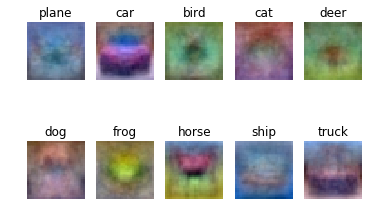

In [128]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])